In [22]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u 
import astropy.units.imperial as ui 
import os 
from pyXSteam.XSteam import XSteam
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator, FormatStrFormatter
from math import pi

ui.enable()
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

if not os.path.exists('figs'): 
    os.mkdir('figs')

from helper import print_value


Reactor Params

In [23]:
from helper import calc_Ax, calc_De, calc_sg_location
steamTable = XSteam(XSteam.UNIT_SYSTEM_FLS)
n_p = 10 
P_c = 22060 * u.kPa
Qdot = 3976 * u.MW
gamma_f = 0.974
P = 1040 * ui.psi
T_fd = 410 * ui.deg_F
F_q = 3.15 
F_z = 1.45 
H_f = (178 * ui.inch).to(ui.ft)
D = (0.4039 * ui.inch).to(ui.ft)
D_i = (0.3441 * ui.inch).to(ui.ft)
R_o = D / 2 
R_i = D_i / 2
D_f = (0.3386 * ui.inch).to(ui.ft)
S = (0.5098 * ui.inch).to(ui.ft)
k_c = 9.6 * ui.BTU / (u.h * ui.ft * ui.deg_F)
H_G = 1200 * ui.BTU / (u.h * ui.ft**2 * ui.deg_F)
n_a = 872 
n_fr_a = 92 
n_fr = n_a * n_fr_a
print(n_fr)
n_w_a = 8 
n = n_a * (n_fr_a + n_w_a)
N_sg = 8 
K_sg = 0.6 
K_in = 1.5 
K_out = 1.0 
K_dc = 2.5
V_d = (280 * ui.inch).to(ui.ft)
C_d = (184 * ui.inch).to(ui.ft)
Ax_dc = pi * (V_d**2 - C_d**2) / 4
De_dc = 4 * Ax_dc / (pi * V_d)
H_c = 12 * ui.ft 
Ax_c = calc_Ax(S, D)
Ax_w = pi * D**2 / 4 
De = calc_De(Ax_c, D)
dz = 1e-2 * ui.ft 
z_range = np.arange(0, H_f.value, dz.value) * ui.ft 
sg_locations = calc_sg_location(N_sg, H_f)
loss_locations = np.zeros((sg_locations.size + 2, )) * ui.ft 
loss_locations[1:-1] = sg_locations
loss_locations[-1] = H_f 
sg_idx = np.zeros(sg_locations.size, int)
K_array = np.zeros((2 + N_sg, ))
K_array[0] = K_in 
K_array[-1] = K_out 
K_array[1:-1] = K_sg 
CPR_goal = 1.28 
QMR_goal = 1.17 
T_melt = 4890 * ui.deg_F
print(R_o, R_i)

80224
0.01682916666666667 ft 0.014337500000000003 ft


Constant Fluid Properties

In [24]:
from helper import martinelli_multiplier
sigma = steamTable.st_p(P.value) * ui.lbf / ui.ft 
h_f = steamTable.hL_p(P.value) * ui.BTU / ui.lbm
h_g = steamTable.hV_p(P.value) * ui.BTU / ui.lbm
h_fg = h_g - h_f
h_fd = steamTable.h_pt(P.value, T_fd.value) * ui.BTU / ui.lbm
rho_f = steamTable.rhoL_p(P.value) * ui.lbm / ui.ft**3 
rho_g = steamTable.rhoV_p(P.value) * ui.lbm / ui.ft**3
mu_f = steamTable.my_ph(P.value, h_f.value) * ui.lb / (ui.ft * u.h)
mu_g = steamTable.my_ph(P.value, h_g.value) * ui.lb / (ui.ft * u.h)
T_sat = steamTable.tsat_p(P.value) * ui.deg_F
Cp = steamTable.CpL_p(P.value) * ui.BTU / (ui.lbm * ui.Fahrenheit)
k = steamTable.tcL_p(P.value) * ui.BTU / (ui.ft * u.h * ui.Fahrenheit)
mdot_fd = (Qdot / (h_g - h_fd)).to(ui.lbm / u.hr)
print_value('mdot_fd', mdot_fd)
print((1 / rho_g - 1 / rho_f) / (1 / rho_f) * 0.2)

mdot_fd = 1.686826E+07 lb / h
3.7266039735655796


Extrapolated Distance

i = 2028757
i = 2028758
Omega = 2.02876


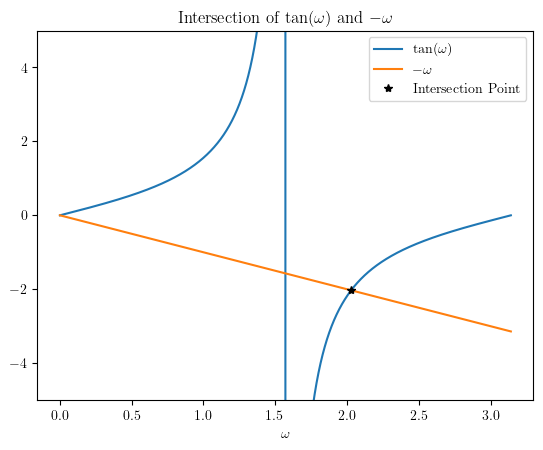

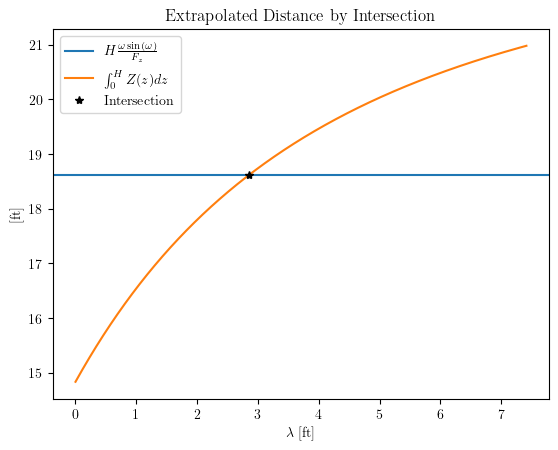

lambda = 2.853000E+00 ft


In [25]:
from helper import find_lambda, int_shape, print_value
lambda_, omega = find_lambda(D, H_f, F_z)
He = 2 * lambda_ + H_f 
z_max = H_f + lambda_ - He * omega / pi

In [26]:
qpp_bar = ((gamma_f * Qdot * H_f) / (n_fr * pi * D * H_f * int_shape(0 * ui.ft, H_f, H_f, lambda_))).to(ui.BTU / (ui.ft**2 * u.hr))
qpp_hot = ((gamma_f * Qdot * F_q) / (n_fr * pi * D * H_f * omega * np.sin(omega))).to(ui.BTU / (ui.ft**2 * u.hr))

print_value('qpp_bar', qpp_bar)
print_value('qpp_hot', qpp_hot)

qpp_bar = 8.368224E+04 BTU / (ft2 h)
qpp_hot = 1.817842E+05 BTU / (ft2 h)


Calculating the mass flux in the hot channel 

In [27]:
from helper import calc_Re, friction_factor, calc_h_bar, non_boiling_height_BOC_CISE_4, enthalpy_profile, qpp_crit_CISE_4
from helper import hc_Weisman, condutivity_int_UO2, fluid_temp, shape, fuel_surface_temp, heat_flux
from helper import G_from_DP, dP_from_G, calc_h_in, x_e, calc_pump_HP
deltaP = 55 * ui.psi 

# dummy starting values 
e = 1e-3
H_0_curr = 1 * ui.ft 
f = 1.2e-2
f_dc = f
x_bar = 0.2
rho_bar = rho_f
rho_l_array = rho_f * np.ones(K_array.shape)
rho_in = rho_f
x_array = np.zeros(K_array.shape)
G_dc = 5e6 * ui.lbm / (ui.ft**2 * u.h)
G_curr = G_from_DP(deltaP, G_dc, f, f_dc, De, De_dc, H_0_curr, H_f, H_c, x_bar, rho_bar, rho_f, rho_g, mu_f, mu_g, rho_l_array, K_array, K_dc, x_array, rho_in, loss_locations)

CPR_curr = 0 
QMR_curr = 0 
T_o_max_hot = T_melt
T_range = np.arange(0, T_melt.value, 1e-2) * T_melt.unit
first = True 
deltaP_vals = np.array([]) * ui.psi

while np.abs(CPR_curr - CPR_goal) >= e * 10 or CPR_curr < CPR_goal or T_o_max_hot >= T_melt:
    # Calculating the mass flux in the average channel 
    deltaP_curr = 0 * deltaP.unit
    while np.abs((deltaP_curr - deltaP).value) >= e: 
        mdot_curr = G_curr * Ax_c 
        G_dc = mdot_curr * n / Ax_dc
        # updating the core inlet enthalpy     
        h_in = calc_h_in(n, mdot_fd, h_fd, mdot_curr, h_f)
        rho_in = steamTable.rho_ph(P.value, h_in.value) * ui.lbm / ui.ft**3
        mu_in = steamTable.my_ph(P.value, h_in.value) * ui.lb / (ui.ft * u.h)
        T_in = steamTable.t_ph(P.value, h_in.value) * ui.deg_F 
        # updating the core average enthalpy 
        h_bar = calc_h_bar(h_in, D, gamma_f, mdot_curr, qpp_bar, H_f, lambda_)
        # updating the core average density 
        rho_bar = steamTable.rho_ph(P.value, h_bar.value) * ui.lbm / ui.ft**3 
        # updating downcomer friction factor 
        Re = calc_Re(G_dc, De_dc, mu_f)
        f_dc = friction_factor(Re)
        # updating friction factor 
        Re = calc_Re(G_curr, De, mu_in)
        f = friction_factor(Re)
        
        # updating the non boiling height 
        H_0_curr = non_boiling_height_BOC_CISE_4(D, G_curr, P, P_c, H_f, lambda_, T_in, De, D, int_shape)
        h_nb = enthalpy_profile(H_0_curr, qpp_hot, H_f, D, mdot_curr, lambda_, h_in, gamma_f)
        h_out = enthalpy_profile(H_f, qpp_hot, H_f, D, mdot_curr, lambda_, h_in, gamma_f)
        x_nb = x_e(h_nb, h_f, h_fg)
        x_out = x_e(h_out, h_f, h_fg)
        #print(x_bar, x_out)
        x_bar = (x_nb + x_out) / 2
        
        # updating the inlet density and quality 
        x_array[0] = x_e(h_in, h_f, h_fg)
        rho_l_array[0] = steamTable.rho_ph(P.value, h_in.value) * ui.lbm / ui.ft**3
        # updating the rho_l_array and x_array for local losses at all spacer grid locations 
        for i in range(1, sg_idx.size + 1): 
            z_curr = sg_locations[i - 1] 
            h_curr = enthalpy_profile(z_curr, qpp_bar, H_f, D, mdot_curr, lambda_, h_in, gamma_f) 
            x_array[i] = x_e(h_curr, h_f, h_fg)
            rho_l_array[i] = steamTable.rho_ph(P.value, h_curr.value) * ui.lbm / ui.ft**3
        h_curr = enthalpy_profile(H_f, qpp_bar, H_f, D, mdot_curr, lambda_, h_in, gamma_f) 
        x_array[-1] = x_e(h_curr, h_f, h_fg)
        rho_l_array[-1] = steamTable.rho_ph(P.value, h_curr.value) * ui.lbm / ui.ft**3
        deltaP_curr = dP_from_G(G_curr, G_dc, f, f_dc, De, De_dc, H_0_curr, H_f, H_c, x_bar, rho_bar, rho_f, rho_g, mu_f, mu_g, rho_l_array, K_array, K_dc, x_array, rho_in, loss_locations)
        if first: 
            deltaP_vals = np.append(deltaP_vals, deltaP_curr)
        diff = np.abs(deltaP_curr - deltaP).value
        if deltaP_curr > deltaP: 
            G_curr -= 1e3 * G_curr.unit * diff 
        if deltaP_curr < deltaP: 
            G_curr += 1e3 * G_curr.unit * diff
        G_dc = G_curr * n * Ax_c / Ax_dc

    if first: 
        first = False 
    # saving the average channel params 
    rho_l_avg = rho_l_array
    x_array_avg = x_array
    x_avg = x_bar 
    G_bar = G_curr 
    H_0_bar = H_0_curr
    rho_bar_core = rho_bar
    # getting the cores average mass flow rate 
    mdot_core = G_curr * n * Ax_c
    deltaP_core = deltaP_curr
    # Calculating the mass flux in the hot channel 
    deltaP_curr = 0 * deltaP.unit
    
    while np.abs((deltaP_curr - deltaP).value) >= e:
        #print(G_curr, G_prev, deltaP_curr)
        mdot_curr = G_curr * Ax_c
        # updating the core average enthalpy 
        h_bar_hot = calc_h_bar(h_in, D, gamma_f, mdot_curr, qpp_hot, H_f, lambda_)
        # updating the core average density 
        rho_bar_hot = steamTable.rho_ph(P.value, h_bar_hot.value) * ui.lbm / ui.ft**3 
        # updating downcomer friction factor 
        Re = calc_Re(G_dc, De_dc, mu_f)
        f_dc = friction_factor(Re)
        # updating friction factor 
        Re = calc_Re(G_curr, De, mu_f)
        f = friction_factor(Re)
        # updating the non boiling height 
        H_0_curr = non_boiling_height_BOC_CISE_4(D, G_curr, P, P_c, H_f, lambda_, T_in, De, D, int_shape)
        # updating the quality at the average boiling height 
        h_nb = enthalpy_profile(H_0_curr, qpp_hot, H_f, D, mdot_curr, lambda_, h_in, gamma_f)
        h_out = enthalpy_profile(H_f, qpp_hot, H_f, D, mdot_curr, lambda_, h_in, gamma_f)
        x_nb = x_e(h_nb, h_f, h_fg)
        x_out = x_e(h_out, h_f, h_fg)
        x_bar =  x_out / 2
        # updating the inlet density and quality 
        x_array[0] = x_e(h_in, h_f, h_fg)
        rho_l_array[0] = steamTable.rho_ph(P.value, h_in.value) * ui.lbm / ui.ft**3
        # updating the rho_l_array and x_array for local losses at all spacer grid locations 
        for i in range(1, sg_idx.size + 1): 
            z_curr = sg_locations[i - 1] 
            h_curr = enthalpy_profile(z_curr, qpp_hot, H_f, D, mdot_curr, lambda_, h_in, gamma_f) 
            x_array[i] = x_e(h_curr, h_f, h_fg)
            rho_l_array[i] = steamTable.rho_ph(P.value, h_curr.value) * ui.lbm / ui.ft**3
        h_curr = enthalpy_profile(H_f, qpp_hot, H_f, D, mdot_curr, lambda_, h_in, gamma_f) 
        x_array[-1] = x_e(h_curr, h_f, h_fg)
        rho_l_array[-1] = steamTable.rho_ph(P.value, h_curr.value) * ui.lbm / ui.ft**3
        deltaP_curr = dP_from_G(G_curr, G_dc, f, f_dc, De, De_dc, H_0_curr, H_f, H_c, x_bar, rho_bar, rho_f, rho_g, mu_f, mu_g, rho_l_array, K_array, K_dc, x_array, rho_in, loss_locations)
        diff = np.abs(deltaP_curr - deltaP).value
        if deltaP_curr > deltaP: 
            G_curr -= 1e3 * G_curr.unit * diff 
        if deltaP_curr < deltaP: 
            G_curr += 1e3 * G_curr.unit * diff
    
    G_hot = G_curr 
    H_0_hot = H_0_curr
    deltaP_hot = deltaP_curr 
    
    # checking the critical power ratio 
    mdot_bar = G_bar * Ax_c
    mdot_hot = G_hot * Ax_c
    qpp_crit_avg = qpp_crit_CISE_4(gamma_f, mdot_bar, h_f, h_in, D, H_0_bar, H_f, lambda_, int_shape)
    qpp_crit_hot = qpp_crit_CISE_4(gamma_f, mdot_hot, h_f, h_in, D, H_0_hot, H_f, lambda_, int_shape)
    CPR_bar = qpp_crit_avg / qpp_bar
    CPR_curr = qpp_crit_hot / qpp_hot 
    
    diff = np.abs(CPR_curr - CPR_goal)
    mult = 100
    if CPR_curr < CPR_goal:
        deltaP = deltaP + mult * diff * deltaP.unit
    elif  CPR_curr > CPR_goal:
        deltaP = deltaP - mult * diff * deltaP.unit
# Maximum fuel centerline temperature in the avg channel 
    hc = hc_Weisman(G_bar, Ax_c, D, S, mu_f, Cp, k)
    T_s_max_avg = fuel_surface_temp(z_max, qpp_crit_avg, P, T_sat, lambda_, H_f, R_o, R_i, H_G, k_c)
    lhs = condutivity_int_UO2(T_range) - condutivity_int_UO2(T_s_max_avg)
    rhs = heat_flux(z_max, qpp_crit_avg, H_f, lambda_) * R_o / 2 
    idx = np.where(lhs.value < rhs.value)[0][-1]
    T_o_max_avg = T_range[idx]

# Maximum fuel centerline temperature in the hot channel 
    hc = hc_Weisman(G_hot, Ax_c, D, S, mu_f, Cp, k)
    T_s_max_hot = fuel_surface_temp(z_max, qpp_crit_hot, P, T_sat, lambda_, H_f, R_o, R_i, H_G, k_c)
    lhs = condutivity_int_UO2(T_range) - condutivity_int_UO2(T_s_max_hot)
    rhs = heat_flux(z_max, qpp_crit_hot, H_f, lambda_) * R_o / 2 
    idx = np.where(lhs.value < rhs.value)[0][-1]
    T_o_max_hot = T_range[idx]

    print('CPR: {:1.8f} T_o_max_hot: {:4.2f} T_o_max_avg {:4.2f}'.format(CPR_curr, T_o_max_hot, T_o_max_avg))

CPR: 1.25463581 T_o_max_hot: 3459.99 deg_F T_o_max_avg 2919.79 deg_F
CPR: 1.27327588 T_o_max_hot: 3521.98 deg_F T_o_max_avg 2965.44 deg_F
CPR: 1.27953772 T_o_max_hot: 3542.83 deg_F T_o_max_avg 2980.79 deg_F
CPR: 1.27955909 T_o_max_hot: 3542.90 deg_F T_o_max_avg 2980.85 deg_F
CPR: 1.27957995 T_o_max_hot: 3542.97 deg_F T_o_max_avg 2980.91 deg_F
CPR: 1.27959985 T_o_max_hot: 3543.03 deg_F T_o_max_avg 2980.96 deg_F
CPR: 1.27961882 T_o_max_hot: 3543.10 deg_F T_o_max_avg 2981.01 deg_F
CPR: 1.27963693 T_o_max_hot: 3543.16 deg_F T_o_max_avg 2981.06 deg_F
CPR: 1.27965476 T_o_max_hot: 3543.22 deg_F T_o_max_avg 2981.11 deg_F
CPR: 1.27967119 T_o_max_hot: 3543.27 deg_F T_o_max_avg 2981.16 deg_F
CPR: 1.27968686 T_o_max_hot: 3543.32 deg_F T_o_max_avg 2981.20 deg_F
CPR: 1.27970229 T_o_max_hot: 3543.37 deg_F T_o_max_avg 2981.24 deg_F
CPR: 1.27983884 T_o_max_hot: 3543.83 deg_F T_o_max_avg 2996.18 deg_F
CPR: 1.27984661 T_o_max_hot: 3543.85 deg_F T_o_max_avg 2996.21 deg_F
CPR: 1.27985378 T_o_max_hot: 3543.

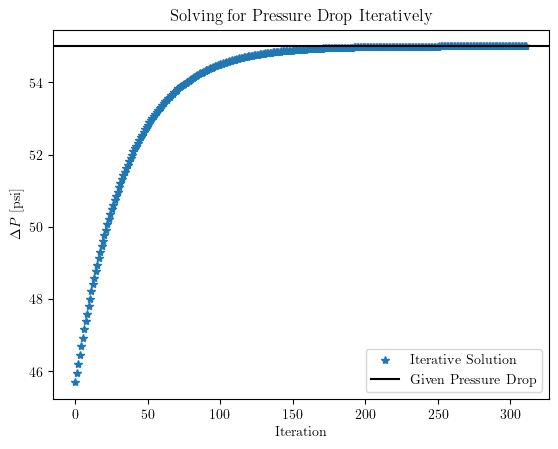

In [28]:
plt.figure() 
plt.title('Solving for Pressure Drop Iteratively')
plt.xlabel('Iteration')
plt.ylabel('$\Delta P$ [psi]')
plt.plot(deltaP_vals, '*')
plt.axhline(55, c='k')
plt.legend(['Iterative Solution', 'Given Pressure Drop'])
plt.savefig('figs/dP_iteration.pdf', format='pdf', bbox_inches='tight')
plt.show() 

In [41]:
deltaP_curr = dP_from_G(G_bar, G_dc, f, f_dc, De, De_dc, H_0_bar, H_f, H_c, x_bar, rho_bar, rho_f, rho_g, mu_f, mu_g, rho_l_array, K_array, K_dc, x_array, rho_in, loss_locations, True)
W_75 = calc_pump_HP(n_p, rho_bar_core, mdot_core, deltaP_core) 
W_80 = calc_pump_HP(n_p, rho_bar_core, mdot_core, deltaP_core, 0.80) 
W_90 = calc_pump_HP(n_p, rho_bar_core, mdot_core, deltaP_core, 0.90) 
print('T_in = {:3.2f}'.format(T_in))
print()
print('H_0_bar = {:0.2f}'.format(H_0_bar.to(ui.ft)))
print('H_0_hot = {:0.2f}'.format(H_0_hot.to(ui.ft)))
print()
print_value('G_dc ', G_dc)
print_value('G_bar', G_bar)
print_value('G_hot', G_hot)
print('mdot_core = {:3.2f}E+06'.format(mdot_core.value / 1e6), mdot_hot.unit)
print()
print('deltaP_avg =', deltaP_core)
print('deltaP_hot =', deltaP_hot)
print()
print('CPR_bar = ', CPR_bar)
print('CPR_hot = ', CPR_curr)
print()
print('T_o_max_avg = {:,.2f}'.format(T_o_max_avg))
print('T_o_max_hot = {:,.2f}'.format(T_o_max_hot))
print()
print('Work per pump assuming 75% efficiency = {:,.2f}'.format(W_75))
print('Work per pump assuming 80% efficiency = {:,.2f}'.format(W_80))
print('Work per pump assuming 90% efficiency = {:,.2f}'.format(W_90))

Core Friction
Loss = 29.315449 psi Quality = 0.136352 Multiplier = 6.010645

Local Core Losses
Loss: 0 = 1.244564 psi Quality = 0.000000 Multiplier: 1.000000
Loss: 1 = 0.793795 psi Quality = 0.016083 Multiplier: 1.594526
Loss: 2 = 1.571117 psi Quality = 0.059631 Multiplier: 3.155960
Loss: 3 = 2.366849 psi Quality = 0.106406 Multiplier: 4.754375
Loss: 4 = 3.101610 psi Quality = 0.151885 Multiplier: 6.230317
Loss: 5 = 3.723615 psi Quality = 0.192384 Multiplier: 7.479762
Loss: 6 = 4.207358 psi Quality = 0.225343 Multiplier: 8.451473
Loss: 7 = 4.548935 psi Quality = 0.249487 Multiplier: 9.137611
Loss: 8 = 4.760738 psi Quality = 0.264857 Multiplier: 9.563068
Loss: 9 = 8.112002 psi Quality = 0.272705 Multiplier: 9.776924

Local Core = 3.443058E+01 psi
f Downcomer = 1.553555E-03 psi
Local Downcomer = 3.683014E-01 psi
Core Elevation = 2.131952E+00 psi
Downcomer Elevation = 3.888551E+00 psi

T_in = 539.78 deg_F

H_0_bar = 0.87 ft
H_0_hot = 0.76 ft

G_dc  = 9.085325E+05 lb / (ft2 h)
G_bar = 2.14

Two Phase Multiplier Scaling 

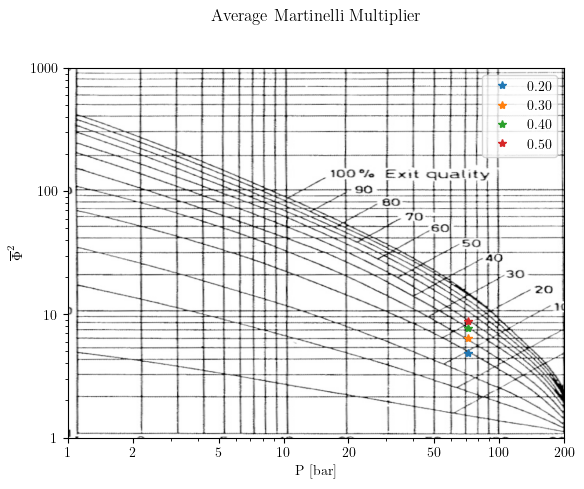

In [30]:
x = np.array([20, 30, 40, 50])/ 100
phis = np.zeros(x.shape)
P_range = np.ones(phis.shape) * P.to(u.bar)
for i in range(x.size):
    phis[i] = martinelli_multiplier(x[i] / 2, mu_f, mu_g, rho_f, rho_g)

xmin = 1
xmax = 1e6
ymin = 1e-2
ymax = xmax
fig, ax = plt.subplots()
im = plt.imread("mult.jpeg")
names = []
for i in range(len(phis)): 
    ax.plot(P.to(u.bar), phis[i], '*')
    names.append('{:.2f}%'.format(x[i]))

ax.legend(names)
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 200])
ax.set_yscale('log')
ax.set_yticks([1, 10, 100, 1000])
ax.get_xaxis().set_major_formatter(ScalarFormatter())
ax.get_yaxis().set_major_formatter(ScalarFormatter())
ax.set_title('Average Martinelli Multiplier')
ax.set_ylabel('$\overline{\Phi}^2$')
ax.set_xlabel('P [bar]')
ax.set_zorder(2)
ax.set_facecolor('none')
ax_tw_x = ax.twinx()
ax_tw_x.axis('off')
ax2 = ax_tw_x.twiny()
ax2.imshow(im, extent=[xmin, xmax, ymin, ymax], aspect='auto')
ax2.axis('off')
plt.savefig('figs/mult_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()

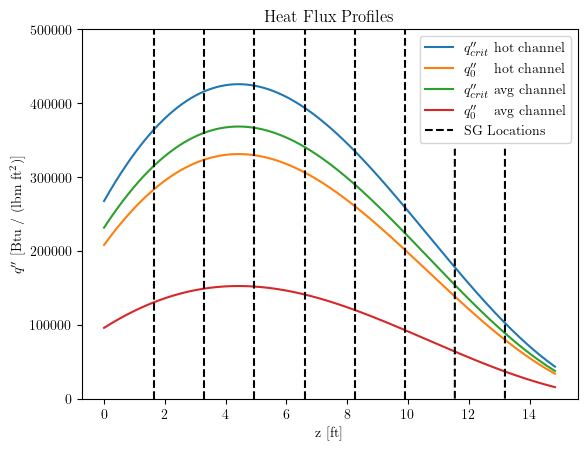

In [31]:
qpp_crit_hot_profile = heat_flux(z_range, qpp_crit_hot, H_f, lambda_)
qpp_hot_profile = heat_flux(z_range, qpp_hot, H_f, lambda_)
qpp_crit_avg_profile = heat_flux(z_range, qpp_crit_avg, H_f, lambda_)
qpp_avg_profile = heat_flux(z_range, qpp_bar, H_f, lambda_)

vline = np.arange(0, np.max(qpp_crit_avg_profile).value - 30000, 1)

plt.figure() 
plt.plot(z_range, qpp_crit_hot_profile)
plt.plot(z_range, qpp_hot_profile)
plt.plot(z_range, qpp_crit_avg_profile)
plt.plot(z_range, qpp_avg_profile)
for z in sg_locations[:-2]: 
    plt.axvline(z.value, c='k', linestyle='--')
for i in range(2): 
    plt.plot(sg_locations[6 + i] * np.ones(vline.shape), vline, '--k')
plt.ylim(0, 500000)
plt.title('Heat Flux Profiles')
plt.legend(['$q\'\'_{crit}$ hot channel', '$q\'\'_0\;\;\;$ hot channel', '$q\'\'_{crit}$ avg channel', '$q\'\'_0\;\;\;$ avg channel', 'SG Locations'], loc='upper right')
plt.xlabel('z [ft]')
plt.ylabel('$q\'\'$ [Btu / (lbm ft${}^2$)]')
plt.savefig('figs/qpp.pdf', format='pdf', bbox_inches='tight')
plt.show() 

Cladding Surface Temperature 

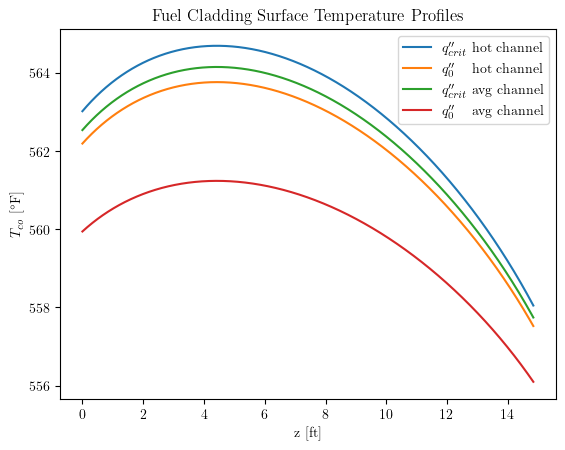

In [32]:
from helper import clad_temp_jens_lottes

T_clad_crit_hot = clad_temp_jens_lottes(z_range, qpp_crit_hot, H_f, lambda_, P, T_sat)
T_clad_hot = clad_temp_jens_lottes(z_range, qpp_hot, H_f, lambda_, P, T_sat)
T_clad_crit_avg = clad_temp_jens_lottes(z_range, qpp_crit_avg, H_f, lambda_, P, T_sat)
T_clad_avg = clad_temp_jens_lottes(z_range, qpp_bar, H_f, lambda_, P, T_sat)

plt.figure() 
plt.plot(z_range, T_clad_crit_hot)
plt.plot(z_range, T_clad_hot)
plt.plot(z_range, T_clad_crit_avg)
plt.plot(z_range, T_clad_avg)
plt.title('Fuel Cladding Surface Temperature Profiles')
plt.legend(['$q\'\'_{crit}$ hot channel', '$q\'\'_0\;\;\;$ hot channel', '$q\'\'_{crit}$ avg channel', '$q\'\'_0\;\;\;$ avg channel'])
plt.xlabel('z [ft]')
plt.ylabel('$T_{co}$ [${}^\circ$F]')
plt.savefig('figs/T_co.pdf', format='pdf', bbox_inches='tight')
plt.show() 

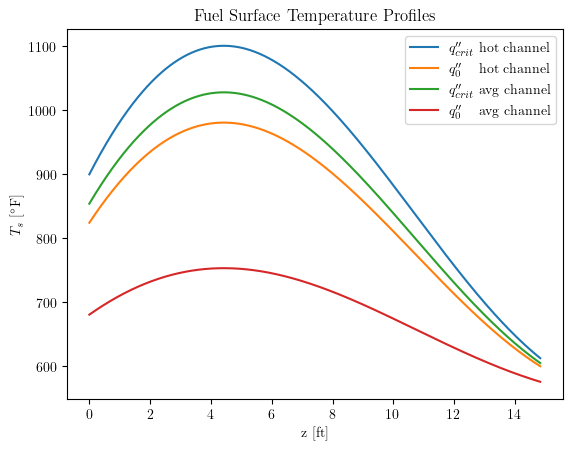

In [33]:
T_s_crit_hot = fuel_surface_temp(z_range, qpp_crit_hot, P, T_sat, lambda_, H_f, R_o, R_i, H_G, k_c)
T_s_hot = fuel_surface_temp(z_range, qpp_hot, P, T_sat, lambda_, H_f, R_o, R_i, H_G, k_c)
T_s_crit_avg = fuel_surface_temp(z_range, qpp_crit_avg, P, T_sat, lambda_, H_f, R_o, R_i, H_G, k_c)
T_s_avg = fuel_surface_temp(z_range, qpp_bar, P, T_sat, lambda_, H_f, R_o, R_i, H_G, k_c)

plt.figure() 
plt.plot(z_range, T_s_crit_hot)
plt.plot(z_range, T_s_hot)
plt.plot(z_range, T_s_crit_avg)
plt.plot(z_range, T_s_avg)
plt.title('Fuel Surface Temperature Profiles')
plt.legend(['$q\'\'_{crit}$ hot channel', '$q\'\'_0\;\;\;$ hot channel', '$q\'\'_{crit}$ avg channel', '$q\'\'_0\;\;\;$ avg channel'])
plt.xlabel('z [ft]')
plt.ylabel('$T_{s}$ [${}^\circ$F]')
plt.savefig('figs/T_s.pdf', format='pdf', bbox_inches='tight')
plt.show() 

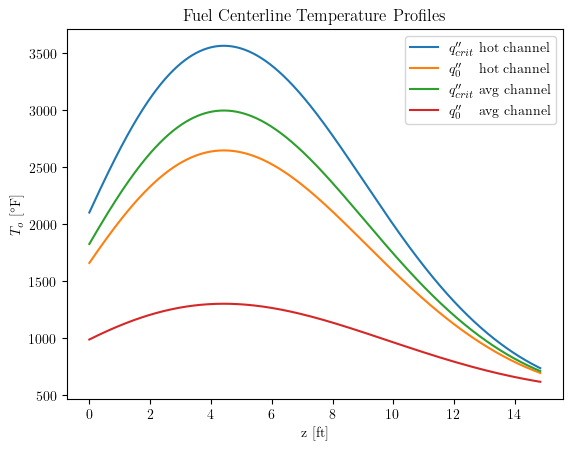

In [34]:
from helper import fuel_centerline_profile
T_o_crit_hot = fuel_centerline_profile(T_s_crit_hot, T_range, z_range, qpp_crit_hot, H_f, lambda_, R_o)
T_o_hot = fuel_centerline_profile(T_s_hot, T_range, z_range, qpp_hot, H_f, lambda_, R_o)
T_o_crit_avg = fuel_centerline_profile(T_s_crit_avg, T_range, z_range, qpp_crit_avg, H_f, lambda_, R_o)
T_o_avg = fuel_centerline_profile(T_s_avg, T_range, z_range, qpp_bar, H_f, lambda_, R_o)

plt.figure() 
plt.plot(z_range, T_o_crit_hot)
plt.plot(z_range, T_o_hot)
plt.plot(z_range, T_o_crit_avg)
plt.plot(z_range, T_o_avg)
plt.title('Fuel Centerline Temperature Profiles')
plt.legend(['$q\'\'_{crit}$ hot channel', '$q\'\'_0\;\;\;$ hot channel', '$q\'\'_{crit}$ avg channel', '$q\'\'_0\;\;\;$ avg channel'])
plt.xlabel('z [ft]')
plt.ylabel('$T_{o}$ [${}^\circ$F]')
plt.savefig('figs/T_o.pdf', format='pdf', bbox_inches='tight')
plt.show() 

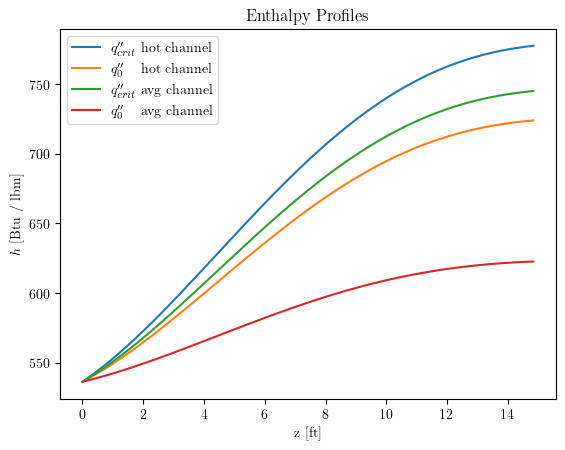

In [35]:
h_crit_hot = enthalpy_profile(z_range, qpp_crit_hot, H_f, D, mdot_hot, lambda_, h_in, gamma_f)
h_hot = enthalpy_profile(z_range, qpp_hot, H_f, D, mdot_hot, lambda_, h_in, gamma_f)
h_crit_avg = enthalpy_profile(z_range, qpp_crit_avg, H_f, D, mdot_bar, lambda_, h_in, gamma_f)
h_avg = enthalpy_profile(z_range, qpp_bar, H_f, D, mdot_bar, lambda_, h_in, gamma_f)

plt.figure() 
plt.plot(z_range, h_crit_hot)
plt.plot(z_range, h_hot)
plt.plot(z_range, h_crit_avg)
plt.plot(z_range, h_avg)
plt.title('Enthalpy Profiles')
plt.legend(['$q\'\'_{crit}$ hot channel', '$q\'\'_0\;\;\;$ hot channel', '$q\'\'_{crit}$ avg channel', '$q\'\'_0\;\;\;$ avg channel'])
plt.xlabel('z [ft]')
plt.ylabel('$h$ [Btu / lbm]')
plt.savefig('figs/h.pdf', format='pdf', bbox_inches='tight')
plt.show() 

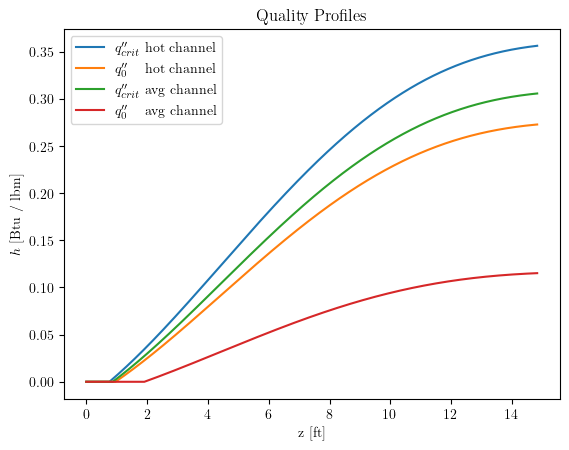

In [36]:
x_crit_hot = np.zeros(z_range.shape) 
x_hot = np.zeros(z_range.shape) 
x_crit_avg = np.zeros(z_range.shape) 
x_avg = np.zeros(z_range.shape) 

for i in range(len(z_range)): 
    x_crit_hot[i] = x_e(h_crit_hot[i], h_f, h_fg)
    x_hot[i] = x_e(h_hot[i], h_f, h_fg)
    x_crit_avg[i] = x_e(h_crit_avg[i], h_f, h_fg)
    x_avg[i] = x_e(h_avg[i], h_f, h_fg)

plt.figure() 
plt.plot(z_range, x_crit_hot)
plt.plot(z_range, x_hot)
plt.plot(z_range, x_crit_avg)
plt.plot(z_range, x_avg)
plt.title('Quality Profiles')
plt.legend(['$q\'\'_{crit}$ hot channel', '$q\'\'_0\;\;\;$ hot channel', '$q\'\'_{crit}$ avg channel', '$q\'\'_0\;\;\;$ avg channel'])
plt.xlabel('z [ft]')
plt.ylabel('$h$ [Btu / lbm]')
plt.savefig('figs/x.pdf', format='pdf', bbox_inches='tight')
plt.show() 

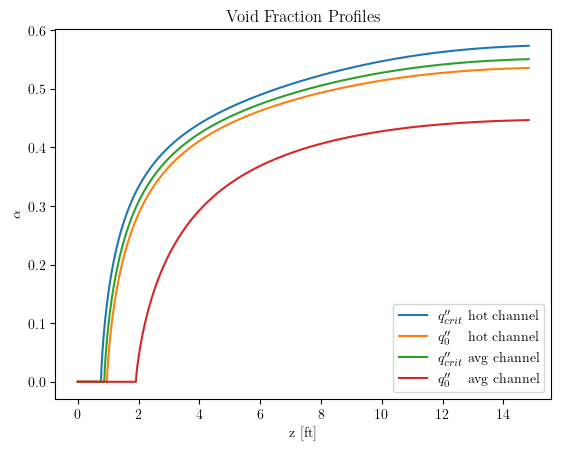

In [37]:
from helper import zuber_findlay

rho_l_crit_hot = np.zeros(z_range.shape) * rho_f.unit 
rho_l_hot = np.zeros(z_range.shape) * rho_f.unit 
rho_l_crit_avg = np.zeros(z_range.shape) * rho_f.unit 
rho_l_avg = np.zeros(z_range.shape) * rho_f.unit 

alpha_crit_hot = np.zeros(z_range.shape)
alpha_hot = np.zeros(z_range.shape)
alpha_crit_avg = np.zeros(z_range.shape)
alpha_avg = np.zeros(z_range.shape)


for i in range(len(z_range)): 
    rho_l_crit_hot[i] = steamTable.rho_ph(P.value, h_crit_hot[i].value) * rho_f.unit 
    rho_l_hot[i] = steamTable.rho_ph(P.value, h_hot[i].value) * rho_f.unit 
    rho_l_crit_avg[i] = steamTable.rho_ph(P.value, h_crit_avg[i].value) * rho_f.unit 
    rho_l_avg[i] = steamTable.rho_ph(P.value, h_avg[i].value) * rho_f.unit 
    
    alpha_crit_hot[i] = zuber_findlay(G_hot, x_crit_hot[i], rho_g, rho_l_crit_hot[i])
    alpha_hot[i] = zuber_findlay(G_hot, x_hot[i], rho_g, rho_l_hot[i])
    alpha_crit_avg[i] = zuber_findlay(G_bar, x_crit_avg[i], rho_g, rho_l_crit_avg[i])
    alpha_avg[i] = zuber_findlay(G_bar, x_avg[i], rho_g, rho_l_avg[i]) 
plt.figure() 
plt.plot(z_range, alpha_crit_hot)
plt.plot(z_range, alpha_hot)
plt.plot(z_range, alpha_crit_avg)
plt.plot(z_range, alpha_avg)
plt.title('Void Fraction Profiles')
plt.legend(['$q\'\'_{crit}$ hot channel', '$q\'\'_0\;\;\;$ hot channel', '$q\'\'_{crit}$ avg channel', '$q\'\'_0\;\;\;$ avg channel'])
plt.xlabel('z [ft]')
plt.ylabel('$\\alpha$')
plt.savefig('figs/alpha.pdf', format='pdf', bbox_inches='tight')
plt.show() 

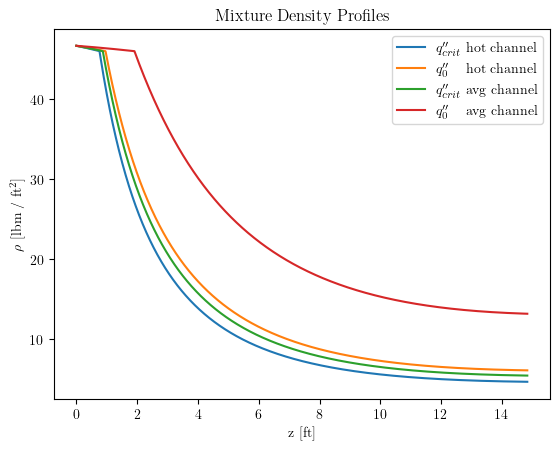

In [38]:
rho_mix_crit_hot = rho_g * x_crit_hot + rho_l_crit_hot * (1 - x_crit_hot)
rho_mix_hot = rho_g * x_hot + rho_l_hot * (1 - x_hot)
rho_mix_crit_avg = rho_g * x_crit_avg + rho_l_crit_avg * (1 - x_crit_avg)
rho_mix_avg = rho_g * x_avg + rho_l_avg * (1 - x_avg)

plt.figure() 
plt.plot(z_range, rho_mix_crit_hot)
plt.plot(z_range, rho_mix_hot)
plt.plot(z_range, rho_mix_crit_avg)
plt.plot(z_range, rho_mix_avg)
plt.title('Mixture Density Profiles')
plt.legend(['$q\'\'_{crit}$ hot channel', '$q\'\'_0\;\;\;$ hot channel', '$q\'\'_{crit}$ avg channel', '$q\'\'_0\;\;\;$ avg channel'])
plt.xlabel('z [ft]')
plt.ylabel('$\\rho$ [lbm / ft${}^2$]')
plt.savefig('figs/rho.pdf', format='pdf', bbox_inches='tight')
plt.show() 